# Overview
Tons of datasets by block through the census [here](https://data.census.gov/cedsci/table?q=United%20States&g=0500000US26163%241000000)

For the population used here, search DECENNIALSF12010.P10

# Status 
Some anomalies. 1/3 of blocks have 0 population. 2/3 of block ids with calls are null when joining on block_id between 911 calls and population data. previous work in [census_blocks](./census_blocks.ipynb) has shown call block ids to be good, so must be something funky with the census one. There are tons of other census data sets though, this is just the first I grabbed

Also, using floats instead of pd.Int64Dtype for block ids because pandas coerces it to something else when you group on it if it's pd.Int64Dtype()

In [2]:
import geopandas as gpd
from util_detroit import kml_to_gpd, csv_with_x_y_to_gpd
import re
import time

pd.options.display.max_rows = 300

# Only read in the columns we want
COLS_911 = [
    "calldescription",
    "call_timestamp", 
    "block_id",
    "category",
    "officerinitiated",
    "priority",
    "oid",
    "longitude",
    "latitude",
]
TYPES_911 = [str, str, float, str, str, str, int, float, float]

In [3]:
# violent
close_proxy = ['ASSAULT','SHOTS','SHOOTING','CUTTING','HOLD UP','WEAP','ROBBERY ARMED','VIOLENT - ARMED','RAPE','STABBED','SHOT']
near_proxy = ['WITH WEAPON','DV','ABUSE','BREAKING AND ENTERING','BREAKING & ENTERING']
expr = re.compile('|'.join(close_proxy))

In [4]:
# use a generator function to select rows we want in chunks rather than loading everything into memory at once
generator = pd.read_csv(
    "calls_for_service_from_jimmy.csv",
    nrows=100000,
    usecols=COLS_911,
    parse_dates=["call_timestamp"],
    chunksize=1e4,
    dtype=dict(zip(COLS_911, TYPES_911)),
)

call = (
    pd.concat(
        [x.loc[lambda x: x.calldescription.str.contains(expr)] for x in generator],
        ignore_index=True,
    )
)

call = gpd.GeoDataFrame(call,geometry=gpd.points_from_xy(call.longitude,call.latitude),crs='epsg:4327')
# Remove some stray data points that are very far away in the same location
call = call.loc[call.longitude > -83.4]

In [6]:
from detroit_geos import get_detroit_census_blocks
blocks = get_detroit_census_blocks(2020)

In [10]:
blocks.head()

,block_id,geometry
0,261635402003021,"POLYGON ((-83.20635 42.43212, -83.20532 42.432..."
1,261635265002009,"POLYGON ((-83.13988 42.35045, -83.13828 42.350..."
2,261635043002003,"POLYGON ((-82.98475 42.41028, -82.98204 42.411..."
3,261635175002005,"POLYGON ((-83.06146 42.35271, -83.05955 42.353..."
4,261635180002028,"POLYGON ((-83.06367 42.35998, -83.06137 42.360..."


In [17]:
call.shape

(7612, 10)

In [18]:
call

,priority,calldescription,category,call_timestamp,officerinitiated,block_id,longitude,latitude,oid,geometry
0,1,FELONIOUS ASSAULT IP,FA IP,2020-06-25 10:53:47-04:04,No,2.616355e+14,-83.219314,42.336093,3079341,POINT (-83.21931 42.33609)
1,2,ASSAULT AND BATTERY IP-JH,AB IP/JH,2020-06-25 10:56:22-04:04,No,2.616354e+14,-83.142711,42.409890,3079346,POINT (-83.14271 42.40989)
3,1,FELONIOUS ASSAULT IP,FA IP,2020-06-25 11:10:09-04:04,No,2.616351e+14,-82.956673,42.392132,3079387,POINT (-82.95667 42.39213)
4,1,SHOOTING/CUTTING/PENT WOUND,GSWCUT,2020-06-25 11:12:11-04:04,No,2.616354e+14,-83.133122,42.422717,3079399,POINT (-83.13312 42.42272)
5,2,ASSAULT AND BATTERY IP-JH,AB IP/JH,2020-06-25 11:26:21-04:04,No,2.616353e+14,-83.081742,42.382823,3079453,POINT (-83.08174 42.38282)
...,...,...,...,...,...,...,...,...,...,...
7649,2,ASSAULT AND BATTERY IP-JH,AB IP/JH,2020-08-02 13:53:51-04:04,No,2.616353e+14,-83.133705,42.333490,3179312,POINT (-83.13371 42.33349)
7650,4,ASSAULT AND BATTERY REPORT,ABRPT,2020-08-02 13:59:47-04:04,No,2.616354e+14,-83.264705,42.412847,3179318,POINT (-83.26470 42.41285)
7651,1,HOLD UP ALARM AND MOW,HOLDUP,2020-08-02 14:09:21-04:04,No,2.616351e+14,-83.076906,42.425739,3179329,POINT (-83.07691 42.42574)
7652,1,FELONIOUS ASSAULT IP,FA IP,2020-08-02 14:22:14-04:04,No,2.616354e+14,-83.161531,42.388446,3179350,POINT (-83.16153 42.38845)


In [19]:
gpd.sjoin(call.loc[:,['geometry']].to_crs('epsg:4327'),blocks.to_crs('epsg:4327'),how='left',predicate='within').block_id

0       261635458001013
1       261635361003011
3       261635027001007
4       261635384002002
5       261635114002031
             ...       
7649    261635258001000
7650    261635442001002
7651    261635071001021
7652    261635366001019
7653    261635032002022
Name: block_id, Length: 7612, dtype: object

In [7]:
call.

,priority,calldescription,category,call_timestamp,officerinitiated,block_id,longitude,latitude,oid,geometry
0,1,FELONIOUS ASSAULT IP,FA IP,2020-06-25 10:53:47-04:04,No,2.616355e+14,-83.219314,42.336093,3079341,POINT (-83.21931 42.33609)
1,2,ASSAULT AND BATTERY IP-JH,AB IP/JH,2020-06-25 10:56:22-04:04,No,2.616354e+14,-83.142711,42.409890,3079346,POINT (-83.14271 42.40989)
3,1,FELONIOUS ASSAULT IP,FA IP,2020-06-25 11:10:09-04:04,No,2.616351e+14,-82.956673,42.392132,3079387,POINT (-82.95667 42.39213)
4,1,SHOOTING/CUTTING/PENT WOUND,GSWCUT,2020-06-25 11:12:11-04:04,No,2.616354e+14,-83.133122,42.422717,3079399,POINT (-83.13312 42.42272)
5,2,ASSAULT AND BATTERY IP-JH,AB IP/JH,2020-06-25 11:26:21-04:04,No,2.616353e+14,-83.081742,42.382823,3079453,POINT (-83.08174 42.38282)


In [132]:
block_count = (
    call.groupby("block_id")
    .oid.count()
    .rename("call_count")
    .sort_values(ascending=False)
)
block_count.head()
# representation_ratio = block_count/block_count.mean()

block_id
2.616354e+14    53
2.616353e+14    50
2.616350e+14    50
2.616355e+14    22
2.616354e+14    22
Name: call_count, dtype: int64

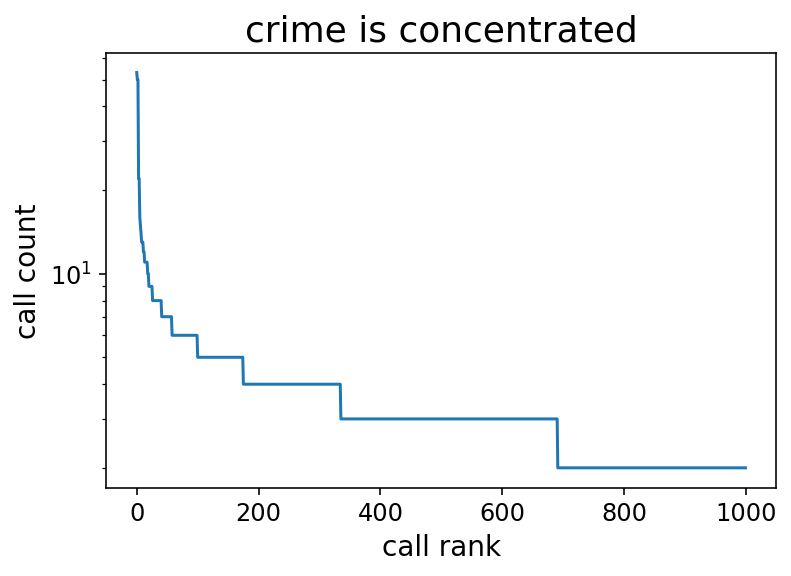

In [133]:
plt.plot(range(1000),block_count.head(1000))
_ = plt.gca().set(yscale='log',title='crime is concentrated',ylabel='call count',xlabel='call rank')

In [192]:
pop = pd.read_csv(
    "/Users/ahakso/Downloads/productDownload_2022-01-28T162855/DECENNIALSF12010.P10_data_with_overlays_2022-01-28T162836.csv",
    usecols=["GEO_ID", "P010001"],
    skiprows=[1],
).rename(columns={"GEO_ID": "block_id", "P010001": "population"})
pop = pop.assign(
    block_id=lambda x: x.block_id.str.split("US").apply(lambda s: s[1])
).astype({"block_id": float})

In [186]:
pop_dec = pd.read_csv(
    "/Users/ahakso/Downloads/productDownload_2022-02-06T092039/DECENNIALPL2020.P1_data_with_overlays_2022-02-06T092022.csv",
#     usecols=["GEO_ID", "P010001"],
#     skiprows=[1],
)

/Users/ahakso/.virtualenvs/detroit/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [189]:
pop_dec2010 = pd.read_csv(
    "/Users/ahakso/Downloads/productDownload_2022-02-06T092039/DECENNIALPL2010.P1_data_with_overlays_2022-02-06T092022.csv",
#     usecols=["GEO_ID", "P010001"],
#     skiprows=[1],
)

/Users/ahakso/.virtualenvs/detroit/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(5557, 145)

In [135]:
block_count.shape

(4363,)

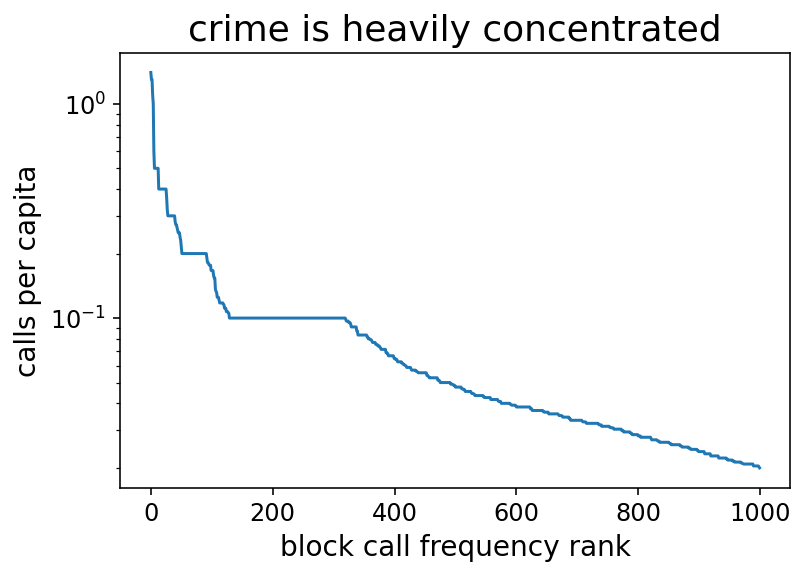

In [136]:
# losing 2/3 of call rows in this join for some reason
df = (
    pd.merge(block_count, pop, left_index=True, right_on="block_id")
#     addition is hack to dilute the impact of zero population zones
    .assign(calls_per_capita=lambda x: x.call_count / (x.population + 10))
    .sort_values("calls_per_capita", ascending=False)
)
plt.plot(range(1000), df.head(1000).calls_per_capita)
_ = plt.gca().set(
    yscale="log",
    title="crime is heavily concentrated",
    ylabel="calls per capita",
    xlabel="block call frequency rank",
)

In [171]:
call.head()

,priority,calldescription,category,call_timestamp,officerinitiated,block_id,longitude,latitude,oid,geometry
0,1,FELONIOUS ASSAULT IP,FA IP,2020-06-25 10:53:47-04:04,No,2.616355e+14,-83.219314,42.336093,3079341,POINT (-83.21931 42.33609)
1,2,ASSAULT AND BATTERY IP-JH,AB IP/JH,2020-06-25 10:56:22-04:04,No,2.616354e+14,-83.142711,42.409890,3079346,POINT (-83.14271 42.40989)
2,4,FELONIOUS ASSAULT REPORT,FA RPT,2020-06-25 10:56:58-04:04,Yes,NaN,-84.132207,42.082976,3079351,POINT (-84.13221 42.08298)
3,1,FELONIOUS ASSAULT IP,FA IP,2020-06-25 11:10:09-04:04,No,2.616351e+14,-82.956673,42.392132,3079387,POINT (-82.95667 42.39213)
4,1,SHOOTING/CUTTING/PENT WOUND,GSWCUT,2020-06-25 11:12:11-04:04,No,2.616354e+14,-83.133122,42.422717,3079399,POINT (-83.13312 42.42272)


In [175]:
import seaborn as sns

In [182]:
pop.columns

Index(['block_id', 'population'], dtype='object')

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

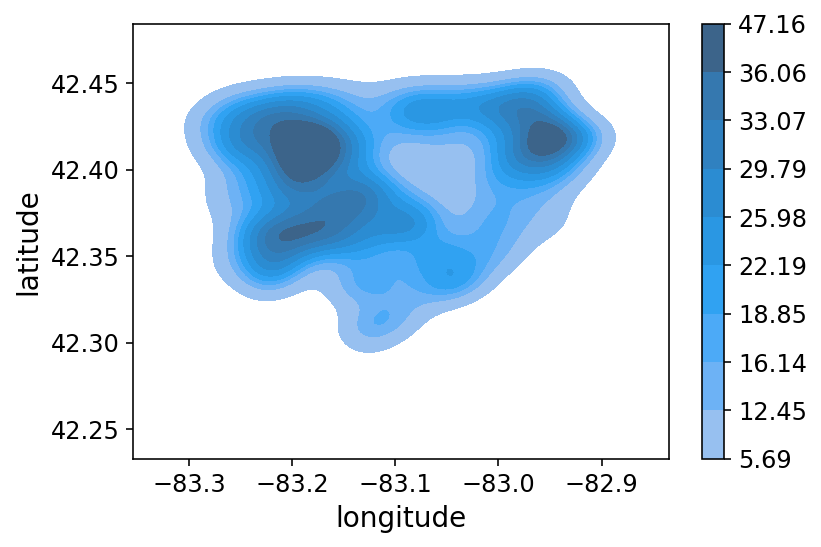

In [181]:
sns.kdeplot(call.longitude, y=call.latitude,shade=True,cbar=True)

In [10]:
call = call.loc[call.longitude > -83.4]
call.plot()

In [1]:
import geopandas as gpd


In [16]:
gpd.GeoDataFrame(csv.head(2),geometry=gpd.points_from_xy(csv.head(2).longitude,csv.head(2).latitude),crs='epsg:4326')

,priority,calldescription,category,call_timestamp,officerinitiated,block_id,longitude,latitude,oid,geometry
0,2,TRAFFIC STOP,TRF STOP,2020-06-25 10:36:55-04:04,Yes,2.616353e+14,-83.113801,42.387110,3079296,POINT (-83.11380 42.38711)
1,3,START OF SHIFT INFORMATION,STRTSHFT,2020-06-25 10:37:21-04:04,Yes,2.616353e+14,-83.081518,42.367313,3079297,POINT (-83.08152 42.36731)


In [ ]:
csv

In [1]:
csv = pd.read_csv(
    "calls_for_service_from_jimmy.csv",
    nrows=1000,
    usecols=COLS_911,
    parse_dates=["call_timestamp"],
#     chunksize=1e4,
    dtype=dict(zip(COLS_911, TYPES_911)),
)

NameError: name 'COLS_911' is not defined

In [12]:
csv.oid.min()

3079296